<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/HAR/UCI_HAR_cnn%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import keras

In [3]:
#라벨 정리
ACTIVITIES={
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS',
    3:'SITTING',
    4:'STANDING',
    5:'LAYING'
}

In [4]:
#혼돈행렬 함수
def confustion_matrix(Y_true, Y_pred):
  Y_true=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
  Y_pred=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

  return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [5]:
DATADIR= os.path.join(os.getcwd(), 'drive','MyDrive','datasets')

SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"]

In [6]:
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename= DATADIR + f'/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)

    return np.transpose(signals_data, (1, 2, 0))

In [7]:
def load_y(subset):
    filename= DATADIR + f'/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0]
    return pd.get_dummies(y).values

In [8]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, y_train, X_test,  y_test

In [9]:
np.random.seed(36)
rn.seed(36)
tf.random.set_seed(36)

In [10]:
#라벨 개수 세기
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
#전에 정리한 데이터셋 불러오기
X_train, Y_train, X_val, Y_val= load_signals('train'), load_y('train'), load_signals('test'), load_y('test')

/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd

In [12]:
class scaling_tseries_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scale = None

    def fit(self, X):
        remove = int(X.shape[1] / 2)
        temp_X = X[:, -remove:, :]
        #데이터 flatten
        temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
        scale = StandardScaler()
        scale.fit(temp_X)
        self.scale = scale
        return self

    def transform(self, X):
        temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
        temp_X1 = self.scale.transform(temp_X1)
        return temp_X1.reshape(X.shape)

In [13]:
#데이터 표준화
Scale= scaling_tseries_data()
Scale.fit(X_train)
X_train_sc= Scale.transform(X_train)
X_val_sc= Scale.transform(X_val)

### CNN+transformer encoder

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Layer, Embedding, Activation
)

In [15]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [17]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])
  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)
  return Add()([attn_output, ffn_output])

In [92]:
def build_cnn_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2):
  inputs=Input(shape=input_shape)

  x=Conv1D(filters=64, kernel_size=7, padding='same')(inputs)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)
  x=MaxPooling1D(pool_size=2)(x)

  x=Conv1D(filters=d_model, kernel_size=5, padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  x=MaxPooling1D(pool_size=2)(x)

  #CNN 출력 시퀀스 길이
  seq_len_cnn=x.shape[1]

  #Transformer Encoder
  x=PositionalEmbedding(seq_len=seq_len_cnn, d_model=d_model)(x)
  x=Dropout(0.2)(x)

  for _ in range(num_transformer_blocks):
    x=transformer_encoder_block(x, d_model, num_heads, ff_dim, dropout=0.3)

  x=GlobalAveragePooling1D()(x)
  x=Dropout(0.4)(x)
  x=Dense(64, activation='relu')(x)
  x=Dropout(0.4)(x)
  outputs=Dense(num_classes, activation='softmax')(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model

In [93]:
INPUT_SHAPE = (X_train_sc.shape[1], X_train_sc.shape[2])
NUM_CLASSES = Y_train.shape[1]

In [94]:
har_model = build_cnn_transformer(
    INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2
)

har_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
har_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 128, 64)   │      4,096 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 64, 64)    │          0 │ activation_16[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 64, 64)    │     20,544 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 32, 64)    │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 32, 64)    │      2,048 │ max_pooling1d_17… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 32, 64)    │          0 │ positional_embed… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ dropout_66[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 32, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 32, 64)    │          0 │ dropout_66[0][0], │
│                     │                   │            │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 32, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 32, 128)   │          0 │ dense_44[0][0]  

 Total params: 98,694 (385.52 KB)

 Trainable params: 98,438 (384.52 KB)

 Non-trainable params: 256 (1.00 KB)

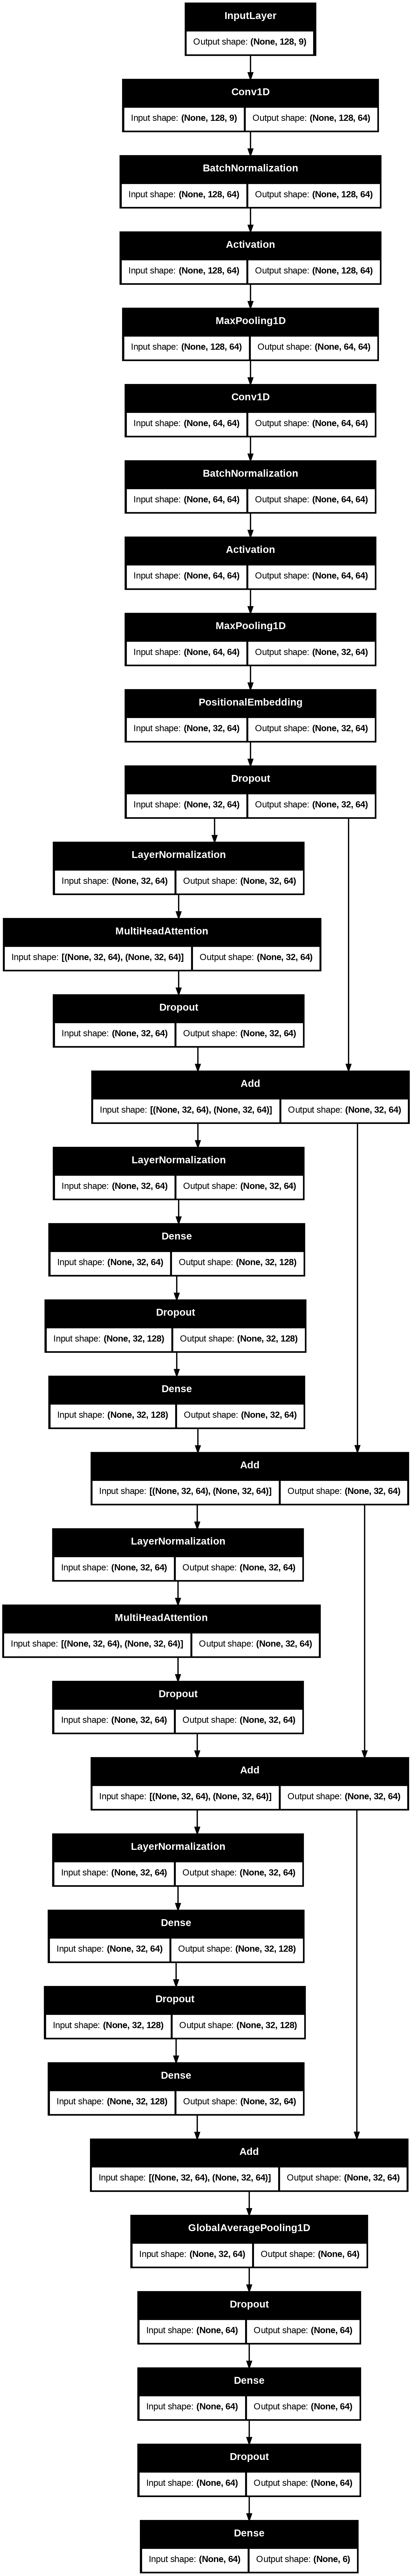

In [95]:
import tensorflow as tf
tf.keras.utils.plot_model(har_model, show_shapes=True)

In [96]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
]


In [97]:
history = har_model.fit(
    X_train_sc,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_sc, Y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.6263 - loss: 0.9618 - val_accuracy: 0.9148 - val_loss: 0.2222
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9278 - loss: 0.2080 - val_accuracy: 0.9213 - val_loss: 0.2183
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9392 - loss: 0.1590 - val_accuracy: 0.9257 - val_loss: 0.2210
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9434 - loss: 0.1446 - val_accuracy: 0.9179 - val_loss: 0.2260
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9478 - loss: 0.1342 - val_accuracy: 0.9250 - val_loss: 0.2053
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9472 - loss: 0.1258 - val_accuracy: 0.9345 - val_loss: 0.2064
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9412 - loss: 0.1609 - val_accuracy: 0.9348 - val_loss: 0.1920
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9484 - loss: 0.1255 - val_accuracy: 

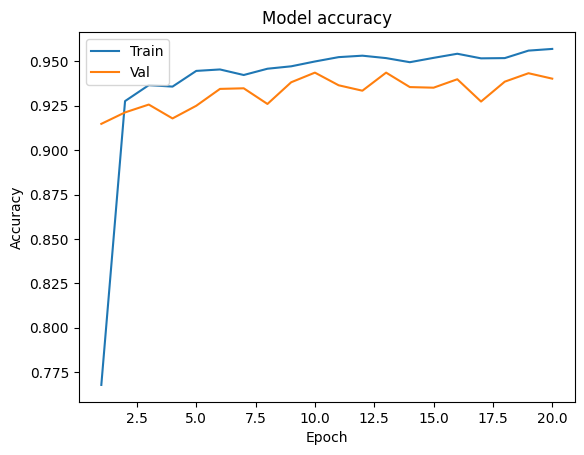

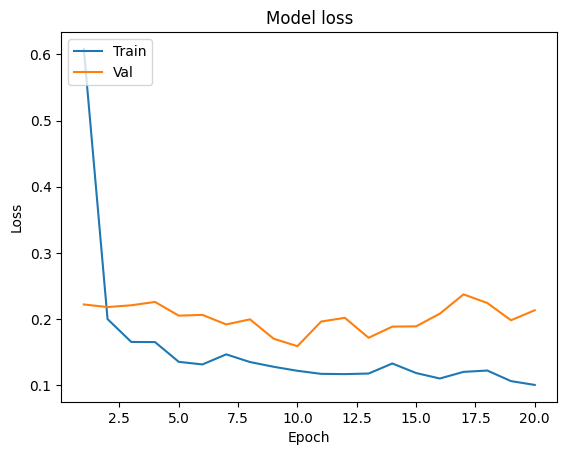

In [98]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 50)

In [99]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [100]:
from sklearn.metrics import classification_report

Y_pred = har_model.predict(X_val_sc)
y_true_indices = np.argmax(Y_val, axis=1)
y_pred_indices = np.argmax(Y_pred, axis=1)
target_names = list(ACTIVITIES.values())

print("\n--- Classification Report ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=target_names))

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       496
  WALKING_UPSTAIRS       0.99      1.00      1.00       471
WALKING_DOWNSTAIRS       1.00      1.00      1.00       420
           SITTING       0.86      0.80      0.83       491
          STANDING       0.83      0.88      0.85       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.94      0.94      0.94      2947




--- Confusion Matrix (Fixed Order) ---


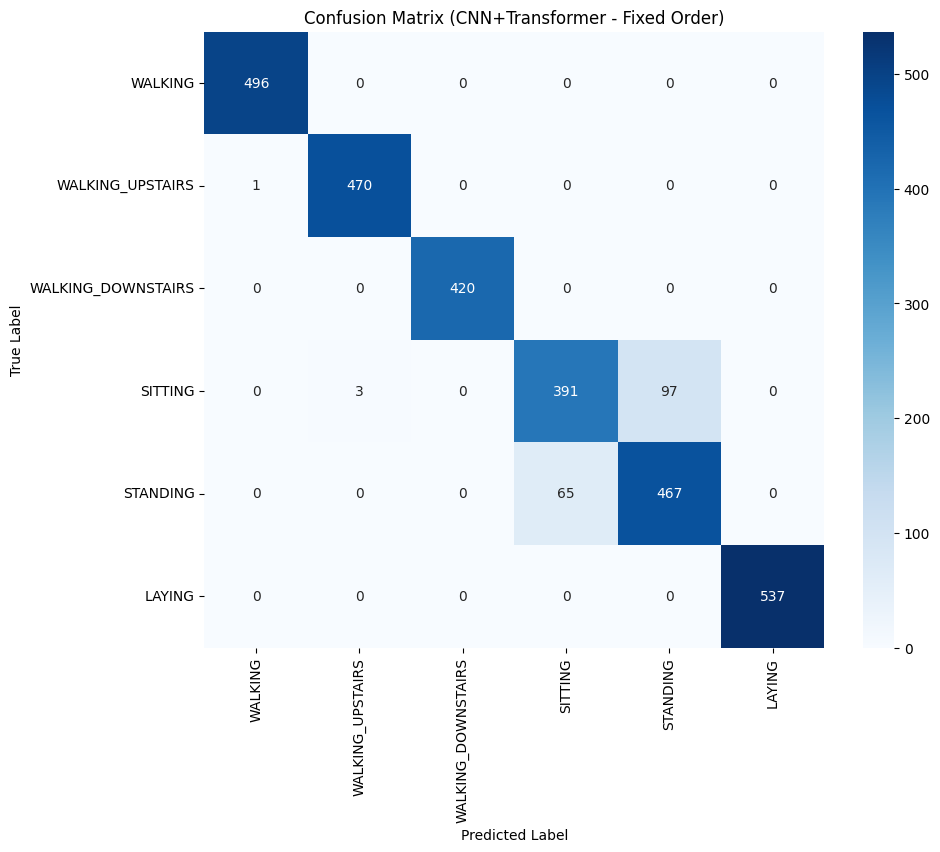

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

def confustion_matrix(Y_true, Y_pred):
    labels = list(ACTIVITIES.values())
    true_labels = pd.Series(
        [ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)],
        name='True'
    )
    true_labels = pd.Categorical(true_labels, categories=labels)
    pred_labels = pd.Series(
        [ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)],
        name='Pred'
    )

    pred_labels = pd.Categorical(pred_labels, categories=labels)
    return pd.crosstab(true_labels, pred_labels, dropna=False)

print("\n--- Confusion Matrix (Fixed Order) ---")
cm_df = confustion_matrix(Y_val, Y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_df.columns,
            yticklabels=cm_df.index)

plt.title("Confusion Matrix (CNN+Transformer - Fixed Order)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()